In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
print sns.__version__
sns.set(style="whitegrid", palette="pastel", color_codes=True)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit

3
0.7.0


In [2]:
# Set up console so we can reattach via terminal ipython later. See:
# https://stackoverflow.com/questions/19479645/using-ipython-console-along-side-ipython-notebook

%qtconsole

# Then do `ipython console --existing` in a terminal to connect and have access to same data!
# But note, do not do CTRL-D in that terminal or it will kill the kernel!

Here I re-wrote `runTest` to use `afwTable.matchXy()` for catalog matching (instead of my own matching).
The resulting numbers are slightly different. The old values were:
    
```
{'ZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack': {'FP': 2, 'FN': 25, 'TP': 25}, 'SZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack_decorr': {'FP': 5, 'FN': 25, 'TP': 25}}
```

In [3]:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=False, skyLimited=True)
res = testObj.runTest(returnSources=True, matchDist=np.sqrt(1.5))
src = res['sources']
del res['sources']
print res

{'ZOGY': {'FP': 3, 'FN': 23, 'TP': 27}, 'ALstack': {'FP': 1, 'FN': 24, 'TP': 26}, 'SZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack_decorr': {'FP': 3, 'FN': 23, 'TP': 27}}


Do forced phot. now with funcs in diffimTests:

In [4]:
reload(dit)
cats = testObj.doForcedPhot(transientsOnly=True)

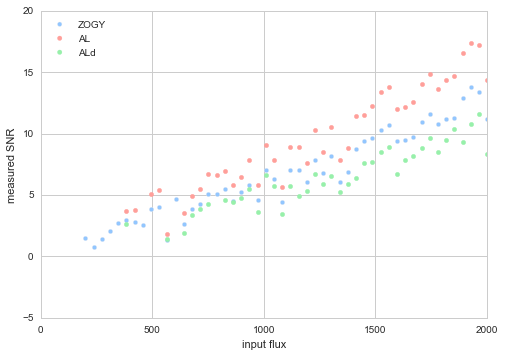

In [5]:
sources, mc1, mc2, mc_ZOGY, mc_AL, mc_ALd = cats
plt.scatter(sources['inputFlux_science'], mc_ZOGY['base_PsfFlux_flux']/mc_ZOGY['base_PsfFlux_fluxSigma'], label='ZOGY')
plt.scatter(sources['inputFlux_science'], mc_AL['base_PsfFlux_flux']/mc_AL['base_PsfFlux_fluxSigma'], label='AL', color='r')
plt.scatter(sources['inputFlux_science'], mc_ALd['base_PsfFlux_flux']/mc_ALd['base_PsfFlux_fluxSigma'], label='ALd', color='g')
plt.legend(loc='upper left')
plt.xlabel('input flux')
plt.ylabel('measured SNR')
plt.xlim(0, 2000);

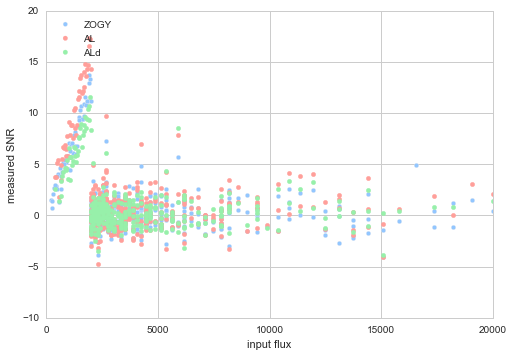

In [6]:
cats = testObj.doForcedPhot(transientsOnly=False)
sources, mc1, mc2, mc_ZOGY, mc_AL, mc_ALd = cats
plt.scatter(sources['inputFlux_science'], mc_ZOGY['base_PsfFlux_flux']/mc_ZOGY['base_PsfFlux_fluxSigma'], label='ZOGY')
plt.scatter(sources['inputFlux_science'], mc_AL['base_PsfFlux_flux']/mc_AL['base_PsfFlux_fluxSigma'], label='AL', color='r')
plt.scatter(sources['inputFlux_science'], mc_ALd['base_PsfFlux_flux']/mc_ALd['base_PsfFlux_fluxSigma'], label='ALd', color='g')
plt.legend(loc='upper left')
plt.xlabel('input flux')
plt.ylabel('measured SNR')
plt.xlim(0, 20000);

Figure out matching. Match sources detected in ZOGY diffim to input sources (transients and not-transients!)

First, `doForcedPhot` gives the forced phot. for all 500 sources in each of the images (and `sources` gives the inputs).

In [7]:
cats = testObj.doForcedPhot(transientsOnly=False)
sources, mc1, mc2, mc_ZOGY, mc_AL, mc_ALd = cats
print len(sources), len(mc_ZOGY)

500 500


Cross-reference the *detections* in ZOGY (`src['ZOGY']`) with the input sources `sources` to identify which of the 50 input transients were detected.

In [8]:
import lsst.afw.table as afwTable
import lsst.afw.table.catalogMatches as catMatch
import lsst.daf.base as dafBase
reload(dit)

matches = afwTable.matchXy(src['ZOGY'], sources, 1.0)
print len(matches)

metadata = dafBase.PropertyList()
matchCat = catMatch.matchesToCatalog(matches, metadata)
dit.sizeme(dit.catalogToDF(matchCat).head())

26


,distance,ref_base_CircularApertureFlux_12_0_flag,ref_base_CircularApertureFlux_12_0_flag_apertureTruncated,ref_base_CircularApertureFlux_12_0_flux,ref_base_CircularApertureFlux_12_0_fluxSigma,ref_base_CircularApertureFlux_17_0_flag,ref_base_CircularApertureFlux_17_0_flag_apertureTruncated,ref_base_CircularApertureFlux_17_0_flux,ref_base_CircularApertureFlux_17_0_fluxSigma,ref_base_CircularApertureFlux_25_0_flag,ref_base_CircularApertureFlux_25_0_flag_apertureTruncated,ref_base_CircularApertureFlux_25_0_flux,ref_base_CircularApertureFlux_25_0_fluxSigma,ref_base_CircularApertureFlux_35_0_flag,ref_base_CircularApertureFlux_35_0_flag_apertureTruncated,ref_base_CircularApertureFlux_35_0_flux,ref_base_CircularApertureFlux_35_0_fluxSigma,ref_base_CircularApertureFlux_3_0_flag,ref_base_CircularApertureFlux_3_0_flag_apertureTruncated,ref_base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,ref_base_CircularApertureFlux_3_0_flux,ref_base_CircularApertureFlux_3_0_fluxSigma,ref_base_CircularApertureFlux_4_5_flag,ref_base_CircularApertureFlux_4_5_flag_apertureTruncated,ref_base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,ref_base_CircularApertureFlux_4_5_flux,ref_base_CircularApertureFlux_4_5_fluxSigma,ref_base_CircularApertureFlux_50_0_flag,ref_base_CircularApertureFlux_50_0_flag_apertureTruncated,ref_base_CircularApertureFlux_50_0_flux,ref_base_CircularApertureFlux_50_0_fluxSigma,ref_base_CircularApertureFlux_6_0_flag,ref_base_CircularApertureFlux_6_0_flag_apertureTruncated,ref_base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,ref_base_CircularApertureFlux_6_0_flux,ref_base_CircularApertureFlux_6_0_fluxSigma,ref_base_CircularApertureFlux_70_0_flag,ref_base_CircularApertureFlux_70_0_flag_apertureTruncated,ref_base_CircularApertureFlux_70_0_flux,ref_base_CircularApertureFlux_70_0_fluxSigma,ref_base_CircularApertureFlux_9_0_flag,ref_base_CircularApertureFlux_9_0_flag_apertureTruncated,ref_base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,ref_base_CircularApertureFlux_9_0_flux,ref_base_CircularApertureFlux_9_0_fluxSigma,ref_base_GaussianCentroid_flag,ref_base_GaussianCentroid_flag_noPeak,ref_base_GaussianCentroid_flag_resetToPeak,ref_base_GaussianCentroid_x,ref_base_GaussianCentroid_y,ref_base_GaussianFlux_flag,ref_base_GaussianFlux_flux,ref_base_GaussianFlux_fluxSigma,ref_base_NaiveCentroid_flag,ref_base_NaiveCentroid_flag_edge,ref_base_NaiveCentroid_flag_noCounts,ref_base_NaiveCentroid_flag_resetToPeak,ref_base_NaiveCentroid_x,ref_base_NaiveCentroid_y,ref_base_PeakCentroid_flag,ref_base_PeakCentroid_x,ref_base_PeakCentroid_y,ref_base_PeakLikelihoodFlux_flag,ref_base_PeakLikelihoodFlux_flux,ref_base_PeakLikelihoodFlux_fluxSigma,ref_base_PixelFlags_flag,ref_base_PixelFlags_flag_bad,ref_base_PixelFlags_flag_cr,ref_base_PixelFlags_flag_crCenter,ref_base_PixelFlags_flag_edge,ref_base_PixelFlags_flag_interpolated,ref_base_PixelFlags_flag_interpolatedCenter,ref_base_PixelFlags_flag_offimage,ref_base_PixelFlags_flag_saturated,ref_base_PixelFlags_flag_saturatedCenter,ref_base_PixelFlags_flag_suspect,ref_base_PixelFlags_flag_suspectCenter,ref_base_PsfFlux_flag,ref_base_PsfFlux_flag_edge,ref_base_PsfFlux_flag_noGoodPixels,ref_base_PsfFlux_flux,ref_base_PsfFlux_fluxSigma,ref_base_SdssCentroid_flag,ref_base_SdssCentroid_flag_almostNoSecondDerivative,ref_base_SdssCentroid_flag_edge,ref_base_SdssCentroid_flag_noSecondDerivative,ref_base_SdssCentroid_flag_notAtMaximum,ref_base_SdssCentroid_flag_resetToPeak,ref_base_SdssCentroid_x,ref_base_SdssCentroid_xSigma,ref_base_SdssCentroid_y,ref_base_SdssCentroid_ySigma,ref_base_SdssShape_flag,ref_base_SdssShape_flag_maxIter,ref_base_SdssShape_flag_psf,ref_base_SdssShape_flag_shift,ref_base_SdssShape_flag_unweighted,ref_base_SdssShape_flag_unweightedBad,ref_base_SdssShape_flux,ref_base_SdssShape_fluxSigma,ref_base_SdssShape_flux_xx_Cov,ref_base_SdssShape_flux_xy_Cov,ref_base_SdssShape_flux_yy_Cov,ref_base_SdssShape_psf_xx,ref_base_SdssShape_psf_xy,ref_base_SdssShape_psf_yy,ref_base_SdssShape_x,re

What do we want to report? Here's a summary:

1. For each input source positively detected in a diffim, what is:<br>
  a. its measured SNR<br>
  b. the measured SNR in the science image `im2`<br>
  c. the input flux of the input source<br>
2. For each source missed in the diffim, what is:<br>
  a. the measured SNR at its location in the diffim<br>
  b. the measured SNR in the science image `im2`<br>
  c. the input flux of the input source<br>
3. For each source falsely detected in a diffim, what is:<br>
  a. the measured SNR at its location in the diffim<br>
  b. the measured SNR at its location in the science image `im2`<br>
  c. is it matched with the location of a static source?
  
To do (1) and (2), we need to run `doForcedPhot` in the diffim on locations of input transients. Need to cross-match (by id) the forced phot. catalog from the diffim with (a) the input catalog; and (b) the forced phot `im2` catalog.

To do (3) we need to run `doForcedPhot` on detections in the diffim, and then cross-match diffim detections (by xy) *and the diffim detection-centered forced-phot)* (including static sources). ~~Need to cross-match the transient detections with (a) the input catalog; and (b) the forced-phot `im2` catalog.~~

Do the detections, save the detected source catalogs (`res`)

In [90]:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=False, skyLimited=True)
res = testObj.runTest(returnSources=True, matchDist=np.sqrt(1.5))
src = res['sources']
del res['sources']
print res

{'ZOGY': {'FP': 3, 'FN': 23, 'TP': 27}, 'ALstack': {'FP': 1, 'FN': 24, 'TP': 26}, 'SZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack_decorr': {'FP': 3, 'FN': 23, 'TP': 27}}


Do forced phot in the ZOGY diffim on locations of input transients.

In [91]:
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = testObj.doForcedPhot(transientsOnly=True)

Do forced phot in the ZOGY diffim and in `im2` on locations of ZOGY detections.

In [105]:
sourcesA, fp1A, fp2A, fp_ZOGYA, fp_ALA, fp_ALdA = testObj.doForcedPhot(centroids=src['ZOGY'])

OK, this first catalog is the input transients (50 of them):

In [93]:
print len(sources)
dit.sizeme(dit.catalogToDF(sources).head())

50


,centroid_x,centroid_y,coord_dec,coord_ra,id,inputFlux_science,inputFlux_template,parent
0,190.250055,268.522124,0.928081,3.761632,1,1853.061224,0.0,0
1,433.697910,382.514098,0.927976,3.761995,2,751.020408,0.0,0
2,139.374588,229.931702,0.928116,3.761556,3,1559.183673,0.0,0
3,139.514874,217.867398,0.928126,3.761556,4,1485.714286,0.0,0
4,462.770744,506.683469,0.927865,3.762039,5,200.000000,0.0,0


And this catalog below is the forced phot. of all 50 input transient locations in the ZOGY diffim:

In [123]:
print len(fp_ZOGY)
dit.sizeme(dit.catalogToDF(fp_ZOGY).head())

50


,base_PsfFlux_flag,base_PsfFlux_flag_edge,base_PsfFlux_flag_noGoodPixels,base_PsfFlux_flux,base_PsfFlux_fluxSigma,base_TransformedCentroid_x,base_TransformedCentroid_y,coord_dec,coord_ra,id,objectId,parent,parentObjectId
0,False,False,False,73.158304,6.512668,190.250055,268.522124,NaN,NaN,1,1,0,0
1,False,False,False,33.296940,6.511562,433.697910,382.514098,NaN,NaN,2,2,0,0
2,False,False,False,69.984365,6.561066,139.374588,229.931702,NaN,NaN,3,3,0,0
3,False,False,False,63.474153,6.584576,139.514874,217.867398,NaN,NaN,4,4,0,0
4,True,True,False,9.857783,6.472410,462.770744,506.683469,NaN,NaN,5,5,0,0


And here is the forced phot of the 31 ZOGY detection locations in the ZOGY diffim:

In [122]:
print len(fp_ZOGYA)
dit.sizeme(dit.catalogToDF(fp_ZOGYA).head())

31


,base_PsfFlux_flag,base_PsfFlux_flag_edge,base_PsfFlux_flag_noGoodPixels,base_PsfFlux_flux,base_PsfFlux_fluxSigma,base_TransformedCentroid_flag,base_TransformedCentroid_x,base_TransformedCentroid_y,coord_dec,coord_ra,id,objectId,parent,parentObjectId
0,True,False,False,-31.321978,6.529918,True,257.000000,169.000000,NaN,NaN,1,1,0,0
1,False,False,False,32.753820,6.551348,False,131.435361,80.443359,NaN,NaN,2,2,0,0
2,False,False,False,40.372565,6.540781,False,256.232681,94.630617,NaN,NaN,3,3,0,0
3,False,False,False,48.759883,6.521134,False,147.322913,108.249915,NaN,NaN,4,4,0,0
4,False,False,False,44.227316,6.498181,False,212.858135,112.239418,NaN,NaN,5,5,0,0


And this catalog below is the matches of the detections in the ZOGY diffim to the input transients (26 matches):

In [117]:
matches = afwTable.matchXy(sources, src['ZOGY'], 1.0)
metadata = dafBase.PropertyList()
matchedCat = catMatch.matchesToCatalog(matches, metadata)

tmp = dit.catalogToDF(matchedCat)
print tmp.shape
dit.sizeme(tmp.ix[np.in1d(tmp['ref_id'], [1,2,3,4,5])])
#dit.sizeme(tmp.head())

(26, 149)


,distance,ref_centroid_x,ref_centroid_y,ref_coord_dec,ref_coord_ra,ref_id,ref_inputFlux_science,ref_inputFlux_template,ref_parent,src_base_CircularApertureFlux_12_0_flag,src_base_CircularApertureFlux_12_0_flag_apertureTruncated,src_base_CircularApertureFlux_12_0_flux,src_base_CircularApertureFlux_12_0_fluxSigma,src_base_CircularApertureFlux_17_0_flag,src_base_CircularApertureFlux_17_0_flag_apertureTruncated,src_base_CircularApertureFlux_17_0_flux,src_base_CircularApertureFlux_17_0_fluxSigma,src_base_CircularApertureFlux_25_0_flag,src_base_CircularApertureFlux_25_0_flag_apertureTruncated,src_base_CircularApertureFlux_25_0_flux,src_base_CircularApertureFlux_25_0_fluxSigma,src_base_CircularApertureFlux_35_0_flag,src_base_CircularApertureFlux_35_0_flag_apertureTruncated,src_base_CircularApertureFlux_35_0_flux,src_base_CircularApertureFlux_35_0_fluxSigma,src_base_CircularApertureFlux_3_0_flag,src_base_CircularApertureFlux_3_0_flag_apertureTruncated,src_base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_3_0_flux,src_base_CircularApertureFlux_3_0_fluxSigma,src_base_CircularApertureFlux_4_5_flag,src_base_CircularApertureFlux_4_5_flag_apertureTruncated,src_base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_4_5_flux,src_base_CircularApertureFlux_4_5_fluxSigma,src_base_CircularApertureFlux_50_0_flag,src_base_CircularApertureFlux_50_0_flag_apertureTruncated,src_base_CircularApertureFlux_50_0_flux,src_base_CircularApertureFlux_50_0_fluxSigma,src_base_CircularApertureFlux_6_0_flag,src_base_CircularApertureFlux_6_0_flag_apertureTruncated,src_base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_6_0_flux,src_base_CircularApertureFlux_6_0_fluxSigma,src_base_CircularApertureFlux_70_0_flag,src_base_CircularApertureFlux_70_0_flag_apertureTruncated,src_base_CircularApertureFlux_70_0_flux,src_base_CircularApertureFlux_70_0_fluxSigma,src_base_CircularApertureFlux_9_0_flag,src_base_CircularApertureFlux_9_0_flag_apertureTruncated,src_base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_9_0_flux,src_base_CircularApertureFlux_9_0_fluxSigma,src_base_GaussianCentroid_flag,src_base_GaussianCentroid_flag_noPeak,src_base_GaussianCentroid_flag_resetToPeak,src_base_GaussianCentroid_x,src_base_GaussianCentroid_y,src_base_GaussianFlux_flag,src_base_GaussianFlux_flux,src_base_GaussianFlux_fluxSigma,src_base_NaiveCentroid_flag,src_base_NaiveCentroid_flag_edge,src_base_NaiveCentroid_flag_noCounts,src_base_NaiveCentroid_flag_resetToPeak,src_base_NaiveCentroid_x,src_base_NaiveCentroid_y,src_base_PeakCentroid_flag,src_base_PeakCentroid_x,src_base_PeakCentroid_y,src_base_PeakLikelihoodFlux_flag,src_base_PeakLikelihoodFlux_flux,src_base_PeakLikelihoodFlux_fluxSigma,src_base_PixelFlags_flag,src_base_PixelFlags_flag_bad,src_base_PixelFlags_flag_cr,src_base_PixelFlags_flag_crCenter,src_base_PixelFlags_flag_edge,src_base_PixelFlags_flag_interpolated,src_base_PixelFlags_flag_interpolatedCenter,src_base_PixelFlags_flag_offimage,src_base_PixelFlags_flag_saturated,src_base_PixelFlags_flag_saturatedCenter,src_base_PixelFlags_flag_suspect,src_base_PixelFlags_flag_suspectCenter,src_base_PsfFlux_flag,src_base_PsfFlux_flag_edge,src_base_PsfFlux_flag_noGoodPixels,src_base_PsfFlux_flux,src_base_PsfFlux_fluxSigma,src_base_SdssCentroid_flag,src_base_SdssCentroid_flag_almostNoSecondDerivative,src_base_SdssCentroid_flag_edge,src_base_SdssCentroid_flag_noSecondDerivative,src_base_SdssCentroid_flag_notAtMaximum,src_base_SdssCentroid_flag_resetToPeak,src_base_SdssCentroid_x,src_base_SdssCentroid_xSigma,src_base_SdssCentroid_y,src_base_SdssCentroid_ySigma,src_base_SdssShape_flag,src_base_SdssShape_flag_maxIter,src_base_SdssShape_flag_psf,src_base_SdssShape_flag_shift,src_base_SdssShape_flag_unweighted,src_base_SdssShape_flag_unweightedBad,src_base_SdssShape_flux,src_base_SdssShape_fluxSigma,src_base_SdssShape_flux_xx_Cov,src_base_SdssShape_flux_xy_Cov,src_base_Sds

And here is the matches of the ZOGY detection-centered forced-phot on the input transients:

In [118]:
matchesA = afwTable.matchXy(sources, fp_ZOGYA, 1.0)
metadata = dafBase.PropertyList()
matchedCatA = catMatch.matchesToCatalog(matchesA, metadata)

tmp = dit.catalogToDF(matchedCatA)
print tmp.shape
dit.sizeme(tmp.ix[np.in1d(tmp['ref_id'], [1,2,3,4,5])])
#dit.sizeme(tmp.head())

(26, 23)


,distance,ref_centroid_x,ref_centroid_y,ref_coord_dec,ref_coord_ra,ref_id,ref_inputFlux_science,ref_inputFlux_template,ref_parent,src_base_PsfFlux_flag,src_base_PsfFlux_flag_edge,src_base_PsfFlux_flag_noGoodPixels,src_base_PsfFlux_flux,src_base_PsfFlux_fluxSigma,src_base_TransformedCentroid_flag,src_base_TransformedCentroid_x,src_base_TransformedCentroid_y,src_coord_dec,src_coord_ra,src_id,src_objectId,src_parent,src_parentObjectId
9,0.462652,139.374588,229.931702,0.928116,3.761556,3,1559.183673,0.0,0,False,False,False,70.218497,6.559293,False,139.606287,229.531249,NaN,NaN,11,11,0,0
14,0.688589,190.250055,268.522124,0.928081,3.761632,1,1853.061224,0.0,0,False,False,False,75.295639,6.511777,False,190.918409,268.687829,NaN,NaN,18,18,0,0


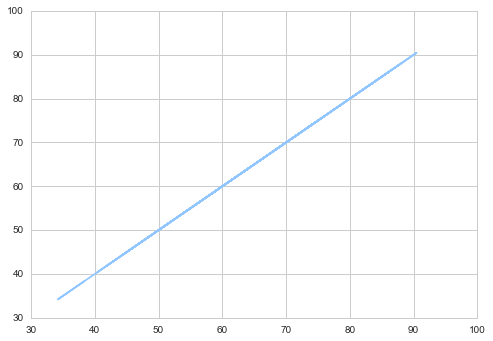

In [116]:
plt.plot(matchedCat['src_base_PsfFlux_flux'], matchedCatA['src_base_PsfFlux_flux'])

### STUFF BELOW IS NOT USED ANYMORE...

Below, we do forced-photemetering on the locations of the detections from the ZOGY diffim. Note that we do not need this anymore.

Here there are 30 detections in ZOGY, 26 are true, and 4 are false, and thus 24 are missed.

Let's print out the table of false detections to see *why* they are detected...

And let's print out the table of false negatives and see *why* they were missed...

In [12]:
reload(dit)
import lsst.afw.table.catalogMatches as catMatch
import lsst.daf.base as dafBase

# First, forced-photometry centered on all 50 positions of input transients

# Convert the input centroids into a catalog...
inputCatalog = dit.centroidsToCatalog(testObj.centroids, testObj.im1.asAfwExposure().getWcs(),
                                     transientsOnly=True)
# Run the forced phot. fp_ZOGY is forced-phot of 50 input transient locations in ZOGY diffim.
cats = testObj.doForcedPhot(inputCatalog)
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats
print len(fp_ZOGY)

# Cross-ref the 50 input transient locations (and their forced phot measurements) 
#    with tbe 27 ZOGY detections
catalog = src['ZOGY'].copy(deep=True)
catalog = catalog[~catalog['base_PsfFlux_flag']]  # this works!
catalog = catalog.copy(deep=True)
zogyDetections = catalog
print len(zogyDetections)
matches = afwTable.matchXy(zogyDetections, inputCatalog, 1.0)
metadata = dafBase.PropertyList()
matchCat = catMatch.matchesToCatalog(matches, metadata)
print len(matchCat)  # matchCat has matches betw. input transients and detected transients -> 26.

dit.sizeme(dit.catalogToDF(matchCat).head())

50
30
26


,distance,ref_base_CircularApertureFlux_12_0_flag,ref_base_CircularApertureFlux_12_0_flag_apertureTruncated,ref_base_CircularApertureFlux_12_0_flux,ref_base_CircularApertureFlux_12_0_fluxSigma,ref_base_CircularApertureFlux_17_0_flag,ref_base_CircularApertureFlux_17_0_flag_apertureTruncated,ref_base_CircularApertureFlux_17_0_flux,ref_base_CircularApertureFlux_17_0_fluxSigma,ref_base_CircularApertureFlux_25_0_flag,ref_base_CircularApertureFlux_25_0_flag_apertureTruncated,ref_base_CircularApertureFlux_25_0_flux,ref_base_CircularApertureFlux_25_0_fluxSigma,ref_base_CircularApertureFlux_35_0_flag,ref_base_CircularApertureFlux_35_0_flag_apertureTruncated,ref_base_CircularApertureFlux_35_0_flux,ref_base_CircularApertureFlux_35_0_fluxSigma,ref_base_CircularApertureFlux_3_0_flag,ref_base_CircularApertureFlux_3_0_flag_apertureTruncated,ref_base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,ref_base_CircularApertureFlux_3_0_flux,ref_base_CircularApertureFlux_3_0_fluxSigma,ref_base_CircularApertureFlux_4_5_flag,ref_base_CircularApertureFlux_4_5_flag_apertureTruncated,ref_base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,ref_base_CircularApertureFlux_4_5_flux,ref_base_CircularApertureFlux_4_5_fluxSigma,ref_base_CircularApertureFlux_50_0_flag,ref_base_CircularApertureFlux_50_0_flag_apertureTruncated,ref_base_CircularApertureFlux_50_0_flux,ref_base_CircularApertureFlux_50_0_fluxSigma,ref_base_CircularApertureFlux_6_0_flag,ref_base_CircularApertureFlux_6_0_flag_apertureTruncated,ref_base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,ref_base_CircularApertureFlux_6_0_flux,ref_base_CircularApertureFlux_6_0_fluxSigma,ref_base_CircularApertureFlux_70_0_flag,ref_base_CircularApertureFlux_70_0_flag_apertureTruncated,ref_base_CircularApertureFlux_70_0_flux,ref_base_CircularApertureFlux_70_0_fluxSigma,ref_base_CircularApertureFlux_9_0_flag,ref_base_CircularApertureFlux_9_0_flag_apertureTruncated,ref_base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,ref_base_CircularApertureFlux_9_0_flux,ref_base_CircularApertureFlux_9_0_fluxSigma,ref_base_GaussianCentroid_flag,ref_base_GaussianCentroid_flag_noPeak,ref_base_GaussianCentroid_flag_resetToPeak,ref_base_GaussianCentroid_x,ref_base_GaussianCentroid_y,ref_base_GaussianFlux_flag,ref_base_GaussianFlux_flux,ref_base_GaussianFlux_fluxSigma,ref_base_NaiveCentroid_flag,ref_base_NaiveCentroid_flag_edge,ref_base_NaiveCentroid_flag_noCounts,ref_base_NaiveCentroid_flag_resetToPeak,ref_base_NaiveCentroid_x,ref_base_NaiveCentroid_y,ref_base_PeakCentroid_flag,ref_base_PeakCentroid_x,ref_base_PeakCentroid_y,ref_base_PeakLikelihoodFlux_flag,ref_base_PeakLikelihoodFlux_flux,ref_base_PeakLikelihoodFlux_fluxSigma,ref_base_PixelFlags_flag,ref_base_PixelFlags_flag_bad,ref_base_PixelFlags_flag_cr,ref_base_PixelFlags_flag_crCenter,ref_base_PixelFlags_flag_edge,ref_base_PixelFlags_flag_interpolated,ref_base_PixelFlags_flag_interpolatedCenter,ref_base_PixelFlags_flag_offimage,ref_base_PixelFlags_flag_saturated,ref_base_PixelFlags_flag_saturatedCenter,ref_base_PixelFlags_flag_suspect,ref_base_PixelFlags_flag_suspectCenter,ref_base_PsfFlux_flag,ref_base_PsfFlux_flag_edge,ref_base_PsfFlux_flag_noGoodPixels,ref_base_PsfFlux_flux,ref_base_PsfFlux_fluxSigma,ref_base_SdssCentroid_flag,ref_base_SdssCentroid_flag_almostNoSecondDerivative,ref_base_SdssCentroid_flag_edge,ref_base_SdssCentroid_flag_noSecondDerivative,ref_base_SdssCentroid_flag_notAtMaximum,ref_base_SdssCentroid_flag_resetToPeak,ref_base_SdssCentroid_x,ref_base_SdssCentroid_xSigma,ref_base_SdssCentroid_y,ref_base_SdssCentroid_ySigma,ref_base_SdssShape_flag,ref_base_SdssShape_flag_maxIter,ref_base_SdssShape_flag_psf,ref_base_SdssShape_flag_shift,ref_base_SdssShape_flag_unweighted,ref_base_SdssShape_flag_unweightedBad,ref_base_SdssShape_flux,ref_base_SdssShape_fluxSigma,ref_base_SdssShape_flux_xx_Cov,ref_base_SdssShape_flux_xy_Cov,ref_base_SdssShape_flux_yy_Cov,ref_base_SdssShape_psf_xx,ref_base_SdssShape_psf_xy,ref_base_SdssShape_psf_yy,ref_base_SdssShape_x,re

In [13]:
# Take the 31 ZOGY detections and force-phot them on the images (fp1, fp2, fp_ZOGY).
cats2 = testObj.doForcedPhot(zogyDetections)
#_, fp1, fp2, fp_ZOGY, _, _ = cats2
print len(cats2[2]), len(cats2[3])

# ... now we need to find the 5 records in cats2 that are not among the 50 input transients.
# We'll do it by (1) matching cats2[2] with inputCatalog, and then finding the rows of cats[2]
# that are *not* in the resulting set of matches.
matches2 = afwTable.matchXy(inputCatalog, cats2[2], 1.0)   # cats2[3] is fp_ZOGY centered at zogyDetections
metadata = dafBase.PropertyList()
matchCat2 = catMatch.matchesToCatalog(matches2, metadata)
print len(matchCat2)

hits_x = np.in1d(cats2[2]['base_TransformedCentroid_x'], matchCat2['src_base_TransformedCentroid_x'])
hits_y = np.in1d(cats2[2]['base_TransformedCentroid_y'], matchCat2['src_base_TransformedCentroid_y'])
tmp_cat = cats2[2][(~hits_x) & (~hits_y)]
tmp_cat = tmp_cat.copy(deep=True)
print len(tmp_cat)

dit.sizeme(dit.catalogToDF(tmp_cat))

30 30
26
4


,base_PsfFlux_flag,base_PsfFlux_flag_edge,base_PsfFlux_flag_noGoodPixels,base_PsfFlux_flux,base_PsfFlux_fluxSigma,base_TransformedCentroid_flag,base_TransformedCentroid_x,base_TransformedCentroid_y,coord_dec,coord_ra,id,objectId,parent,parentObjectId
0,False,False,False,814.042878,122.324422,False,131.435361,80.443359,NaN,NaN,1,2,0,0
1,False,False,False,784.191755,122.557015,False,38.555258,260.821493,NaN,NaN,16,17,0,0
2,False,False,False,797.512093,122.377833,False,432.493299,383.226461,NaN,NaN,25,26,0,0
3,False,False,False,1191.771226,122.387826,False,221.419567,402.159643,NaN,NaN,27,28,0,0


In [76]:
reload(dit)
df = dit.catalogToDF(tmp_cat)
#tmp = dit.dfToCatalog(df)
#dt2 = dit.catalogToDF(tmp)
#dit.sizeme(dt2.head())